# Method 2 - Best Ideas Low Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

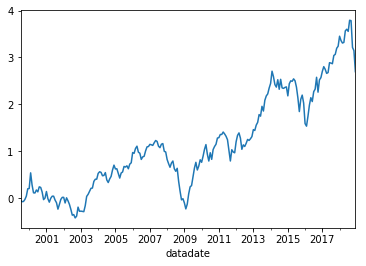

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.197943
2000-12-31   -0.164748
2001-12-31    0.014997
2002-12-31   -0.293046
2003-12-31    0.955722
2004-12-31    0.212727
2005-12-31    0.029339
2006-12-31    0.198090
2007-12-31   -0.055088
2008-12-31   -0.502535
2009-12-31    0.840551
2010-12-31    0.255248
2011-12-31   -0.137945
2012-12-31    0.175903
2013-12-31    0.447801
2014-12-31    0.007388
2015-12-31   -0.102374
2016-12-31    0.178708
2017-12-31    0.188400
2018-12-31   -0.128161
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     422.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.26e-104
Time:                        02:50:22   Log-Likelihood:                 517.82
No. Observations:                 234   AIC:                            -1026.
Df Residuals:                     229   BIC:                            -1008.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.785      0.006       0.001       0.009
mktrf          1.0011      0.050     20.061      0.000       0.903       1.099
me             0.6239      0.058     10.749      0.000       0.510       0.738
ia             0.0270      0.088      0.306      0.760      -0.147       0.201
roe           -0.8485      0.076    -11.237      0.000      -0.997      -0.700
==============================================================================
Omnibus:                       70.632   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              384.445
Skew:                           1.056   Prob(JB):                     3.30e-84
Kurtosis:                       8.913   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     179.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.99e-69
Time:                        02:50:22   Log-Likelihood:                 517.82
No. Observations:                 234   AIC:                            -1026.
Df Residuals:                     229   BIC:                            -1008.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.620      0.009       0.001       0.009
mktrf          1.0011      0.053     18.962      0.000       0.898       1.105
me             0.6239      0.075      8.369      0.000       0.478       0.770
ia             0.0270      0.145      0.186      0.853      -0.257       0.311
roe           -0.8485      0.155     -5.471      0.000      -1.153      -0.545
==============================================================================
Omnibus:                       70.632   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              384.445
Skew:                           1.056   Prob(JB):                     3.30e-84
Kurtosis:                       8.913   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     186.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.19e-71
Time:                        02:50:22   Log-Likelihood:                 517.82
No. Observations:                 234   AIC:                            -1026.
Df Residuals:                     229   BIC:                            -1008.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.002      2.546      0.011       0.001       0.009
mktrf          1.0011      0.046     21.865      0.000       0.911       1.091
me             0.6239      0.078      8.047      0.000       0.472       0.776
ia             0.0270      0.135      0.199      0.842      -0.239       0.292
roe           -0.8485      0.167     -5.083      0.000      -1.176      -0.521
==============================================================================
Omnibus:                       70.632   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              384.445
Skew:                           1.056   Prob(JB):                     3.30e-84
Kurtosis:                       8.913   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     291.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.92e-97
Time:                        02:50:22   Log-Likelihood:                 503.43
No. Observations:                 234   AIC:                            -994.9
Df Residuals:                     228   BIC:                            -974.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.220      0.027       0.000       0.008
mktrf          1.1018      0.053     20.677      0.000       0.997       1.207
smb            0.6148      0.070      8.744      0.000       0.476       0.753
hml            0.0746      0.083      0.899      0.369      -0.089       0.238
rmw           -0.7858      0.094     -8.383      0.000      -0.971      -0.601
cma            0.1774      0.119      1.489      0.138      -0.057       0.412
==============================================================================
Omnibus:                       61.864   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.069
Skew:                           1.005   Prob(JB):                     8.23e-55
Kurtosis:                       7.637   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     122.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.13e-62
Time:                        02:50:22   Log-Likelihood:                 503.43
No. Observations:                 234   AIC:                            -994.9
Df Residuals:                     228   BIC:                            -974.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      2.059      0.039       0.000       0.009
mktrf          1.1018      0.052     21.248      0.000       1.000       1.203
smb            0.6148      0.069      8.917      0.000       0.480       0.750
hml            0.0746      0.124      0.602      0.547      -0.168       0.318
rmw           -0.7858      0.161     -4.886      0.000      -1.101      -0.471
cma            0.1774      0.183      0.971      0.331      -0.181       0.535
==============================================================================
Omnibus:                       61.864   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.069
Skew:                           1.005   Prob(JB):                     8.23e-55
Kurtosis:                       7.637   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     143.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.82e-68
Time:                        02:50:23   Log-Likelihood:                 503.43
No. Observations:                 234   AIC:                            -994.9
Df Residuals:                     228   BIC:                            -974.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0044      0.002      1.936      0.053   -5.33e-05       0.009
mktrf          1.1018      0.053     20.626      0.000       0.997       1.207
smb            0.6148      0.066      9.269      0.000       0.485       0.745
hml            0.0746      0.103      0.721      0.471      -0.128       0.277
rmw           -0.7858      0.168     -4.682      0.000      -1.115      -0.457
cma            0.1774      0.158      1.125      0.261      -0.132       0.487
==============================================================================
Omnibus:                       61.864   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.069
Skew:                           1.005   Prob(JB):                     8.23e-55
Kurtosis:                       7.637   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     305.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.46e-90
Time:                        02:50:23   Log-Likelihood:                 485.28
No. Observations:                 234   AIC:                            -960.6
Df Residuals:                     229   BIC:                            -943.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.061      0.290      -0.002       0.006
mktrf          1.1675      0.053     22.113      0.000       1.063       1.272
smb            0.9442      0.066     14.326      0.000       0.814       1.074
hml           -0.0064      0.065     -0.098      0.922      -0.135       0.123
umd           -0.2464      0.043     -5.736      0.000      -0.331      -0.162
==============================================================================
Omnibus:                       67.276   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.642
Skew:                           1.019   Prob(JB):                     3.95e-75
Kurtosis:                       8.567   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     182.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.70e-70
Time:                        02:50:23   Log-Likelihood:                 485.28
No. Observations:                 234   AIC:                            -960.6
Df Residuals:                     229   BIC:                            -943.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.180      0.238      -0.001       0.006
mktrf          1.1675      0.056     20.873      0.000       1.058       1.277
smb            0.9442      0.105      8.964      0.000       0.738       1.151
hml           -0.0064      0.099     -0.065      0.948      -0.201       0.188
umd           -0.2464      0.083     -2.958      0.003      -0.410      -0.083
==============================================================================
Omnibus:                       67.276   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.642
Skew:                           1.019   Prob(JB):                     3.95e-75
Kurtosis:                       8.567   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     226.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.24e-78
Time:                        02:50:23   Log-Likelihood:                 485.28
No. Observations:                 234   AIC:                            -960.6
Df Residuals:                     229   BIC:                            -943.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.231      0.218      -0.001       0.006
mktrf          1.1675      0.052     22.539      0.000       1.066       1.269
smb            0.9442      0.098      9.671      0.000       0.753       1.135
hml           -0.0064      0.092     -0.070      0.945      -0.188       0.175
umd           -0.2464      0.082     -3.019      0.003      -0.406      -0.086
==============================================================================
Omnibus:                       67.276   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.642
Skew:                           1.019   Prob(JB):                     3.95e-75
Kurtosis:                       8.567   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     196.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.06e-50
Time:                        02:50:23   Log-Likelihood:                 241.61
No. Observations:                 120   AIC:                            -473.2
Df Residuals:                     115   BIC:                            -459.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.003      2.426      0.017       0.001       0.014
mktrf          0.9724      0.085     11.430      0.000       0.804       1.141
me             0.6257      0.084      7.446      0.000       0.459       0.792
ia             0.1133      0.132      0.861      0.391      -0.147       0.374
roe           -0.8958      0.116     -7.692      0.000      -1.126      -0.665
==============================================================================
Omnibus:                       26.100   Durbin-Watson:                   2.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.016
Skew:                           0.761   Prob(JB):                     2.30e-16
Kurtosis:                       6.476   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     102.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.47e-37
Time:                        02:50:23   Log-Likelihood:                 241.61
No. Observations:                 120   AIC:                            -473.2
Df Residuals:                     115   BIC:                            -459.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.003      2.479      0.013       0.002       0.014
mktrf          0.9724      0.087     11.237      0.000       0.803       1.142
me             0.6257      0.103      6.057      0.000       0.423       0.828
ia             0.1133      0.195      0.581      0.561      -0.269       0.495
roe           -0.8958      0.210     -4.274      0.000      -1.307      -0.485
==============================================================================
Omnibus:                       26.100   Durbin-Watson:                   2.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.016
Skew:                           0.761   Prob(JB):                     2.30e-16
Kurtosis:                       6.476   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     109.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.58e-38
Time:                        02:50:23   Log-Likelihood:                 241.61
No. Observations:                 120   AIC:                            -473.2
Df Residuals:                     115   BIC:                            -459.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.003      2.530      0.011       0.002       0.014
mktrf          0.9724      0.075     12.969      0.000       0.825       1.119
me             0.6257      0.108      5.771      0.000       0.413       0.838
ia             0.1133      0.180      0.631      0.528      -0.239       0.465
roe           -0.8958      0.225     -3.978      0.000      -1.337      -0.454
==============================================================================
Omnibus:                       26.100   Durbin-Watson:                   2.301
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.016
Skew:                           0.761   Prob(JB):                     2.30e-16
Kurtosis:                       6.476   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     148.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.16e-48
Time:                        02:50:23   Log-Likelihood:                 239.15
No. Observations:                 120   AIC:                            -466.3
Df Residuals:                     114   BIC:                            -449.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.003      2.645      0.009       0.002       0.015
mktrf          1.1279      0.092     12.265      0.000       0.946       1.310
smb            0.6013      0.104      5.773      0.000       0.395       0.808
hml            0.0950      0.128      0.745      0.458      -0.158       0.348
rmw           -0.8376      0.151     -5.565      0.000      -1.136      -0.539
cma            0.2926      0.165      1.775      0.079      -0.034       0.619
==============================================================================
Omnibus:                       24.661   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.156
Skew:                           0.807   Prob(JB):                     1.74e-12
Kurtosis:                       5.868   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     68.39
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.06e-32
Time:                        02:50:23   Log-Likelihood:                 239.15
No. Observations:                 120   AIC:                            -466.3
Df Residuals:                     114   BIC:                            -449.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.003      2.758      0.006       0.003       0.015
mktrf          1.1279      0.089     12.687      0.000       0.954       1.302
smb            0.6013      0.105      5.752      0.000       0.396       0.806
hml            0.0950      0.191      0.498      0.619      -0.279       0.469
rmw           -0.8376      0.234     -3.574      0.000      -1.297      -0.378
cma            0.2926      0.202      1.446      0.148      -0.104       0.689
==============================================================================
Omnibus:                       24.661   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.156
Skew:                           0.807   Prob(JB):                     1.74e-12
Kurtosis:                       5.868   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     83.57
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.75e-36
Time:                        02:50:23   Log-Likelihood:                 239.15
No. Observations:                 120   AIC:                            -466.3
Df Residuals:                     114   BIC:                            -449.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0088      0.003      2.703      0.007       0.002       0.015
mktrf          1.1279      0.088     12.814      0.000       0.955       1.300
smb            0.6013      0.104      5.794      0.000       0.398       0.805
hml            0.0950      0.181      0.526      0.599      -0.259       0.449
rmw           -0.8376      0.249     -3.363      0.001      -1.326      -0.349
cma            0.2926      0.158      1.853      0.064      -0.017       0.602
==============================================================================
Omnibus:                       24.661   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.156
Skew:                           0.807   Prob(JB):                     1.74e-12
Kurtosis:                       5.868   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     153.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.10e-45
Time:                        02:50:23   Log-Likelihood:                 228.84
No. Observations:                 120   AIC:                            -447.7
Df Residuals:                     115   BIC:                            -433.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.003      1.575      0.118      -0.001       0.012
mktrf          1.2058      0.083     14.465      0.000       1.041       1.371
smb            0.9949      0.095     10.483      0.000       0.807       1.183
hml            0.0092      0.095      0.097      0.923      -0.179       0.198
umd           -0.2458      0.059     -4.194      0.000      -0.362      -0.130
==============================================================================
Omnibus:                       32.199   Durbin-Watson:                   2.382
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.010
Skew:                           0.875   Prob(JB):                     7.84e-25
Kurtosis:                       7.375   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     89.61
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.05e-34
Time:                        02:50:23   Log-Likelihood:                 228.84
No. Observations:                 120   AIC:                            -447.7
Df Residuals:                     115   BIC:                            -433.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.003      2.054      0.040       0.000       0.011
mktrf          1.2058      0.084     14.285      0.000       1.040       1.371
smb            0.9949      0.131      7.595      0.000       0.738       1.252
hml            0.0092      0.125      0.074      0.941      -0.235       0.254
umd           -0.2458      0.096     -2.564      0.010      -0.434      -0.058
==============================================================================
Omnibus:                       32.199   Durbin-Watson:                   2.382
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.010
Skew:                           0.875   Prob(JB):                     7.84e-25
Kurtosis:                       7.375   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     114.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.04e-39
Time:                        02:50:23   Log-Likelihood:                 228.84
No. Observations:                 120   AIC:                            -447.7
Df Residuals:                     115   BIC:                            -433.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.002      2.347      0.019       0.001       0.010
mktrf          1.2058      0.076     15.862      0.000       1.057       1.355
smb            0.9949      0.124      8.035      0.000       0.752       1.238
hml            0.0092      0.126      0.073      0.942      -0.237       0.256
umd           -0.2458      0.090     -2.726      0.006      -0.423      -0.069
==============================================================================
Omnibus:                       32.199   Durbin-Watson:                   2.382
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.010
Skew:                           0.875   Prob(JB):                     7.84e-25
Kurtosis:                       7.375   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     293.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.44e-57
Time:                        02:50:23   Log-Likelihood:                 302.40
No. Observations:                 114   AIC:                            -594.8
Df Residuals:                     109   BIC:                            -581.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.924      0.358      -0.002       0.005
mktrf          1.0903      0.051     21.268      0.000       0.989       1.192
me             0.5203      0.079      6.573      0.000       0.363       0.677
ia            -0.2399      0.110     -2.185      0.031      -0.458      -0.022
roe           -0.8767      0.096     -9.087      0.000      -1.068      -0.685
==============================================================================
Omnibus:                        7.254   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                8.821
Skew:                           0.356   Prob(JB):                       0.0121
Kurtosis:                       4.162   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     381.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.28e-63
Time:                        02:50:23   Log-Likelihood:                 302.40
No. Observations:                 114   AIC:                            -594.8
Df Residuals:                     109   BIC:                            -581.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.074      0.283      -0.001       0.005
mktrf          1.0903      0.039     28.029      0.000       1.014       1.167
me             0.5203      0.047     11.127      0.000       0.429       0.612
ia            -0.2399      0.108     -2.216      0.027      -0.452      -0.028
roe           -0.8767      0.119     -7.365      0.000      -1.110      -0.643
==============================================================================
Omnibus:                        7.254   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                8.821
Skew:                           0.356   Prob(JB):                       0.0121
Kurtosis:                       4.162   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     503.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.87e-69
Time:                        02:50:23   Log-Likelihood:                 302.40
No. Observations:                 114   AIC:                            -594.8
Df Residuals:                     109   BIC:                            -581.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.229      0.219      -0.001       0.004
mktrf          1.0903      0.034     31.665      0.000       1.023       1.158
me             0.5203      0.042     12.308      0.000       0.437       0.603
ia            -0.2399      0.107     -2.242      0.025      -0.450      -0.030
roe           -0.8767      0.115     -7.610      0.000      -1.102      -0.651
==============================================================================
Omnibus:                        7.254   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                8.821
Skew:                           0.356   Prob(JB):                       0.0121
Kurtosis:                       4.162   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     166.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.17e-49
Time:                        02:50:23   Log-Likelihood:                 285.40
No. Observations:                 114   AIC:                            -558.8
Df Residuals:                     108   BIC:                            -542.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.196      0.845      -0.004       0.004
mktrf          1.1365      0.057     19.933      0.000       1.024       1.250
smb            0.5304      0.093      5.730      0.000       0.347       0.714
hml            0.1059      0.118      0.897      0.371      -0.128       0.340
rmw           -0.8009      0.145     -5.541      0.000      -1.087      -0.514
cma           -0.2283      0.183     -1.244      0.216      -0.592       0.135
==============================================================================
Omnibus:                        2.203   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.332   Jarque-Bera (JB):                1.658
Skew:                           0.203   Prob(JB):                        0.436
Kurtosis:                       3.428   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     182.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.09e-51
Time:                        02:50:23   Log-Likelihood:                 285.40
No. Observations:                 114   AIC:                            -558.8
Df Residuals:                     108   BIC:                            -542.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.191      0.848      -0.004       0.004
mktrf          1.1365      0.051     22.242      0.000       1.036       1.237
smb            0.5304      0.067      7.968      0.000       0.400       0.661
hml            0.1059      0.171      0.620      0.535      -0.229       0.441
rmw           -0.8009      0.204     -3.934      0.000      -1.200      -0.402
cma           -0.2283      0.169     -1.350      0.177      -0.560       0.103
==============================================================================
Omnibus:                        2.203   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.332   Jarque-Bera (JB):                1.658
Skew:                           0.203   Prob(JB):                        0.436
Kurtosis:                       3.428   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     223.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.00e-55
Time:                        02:50:23   Log-Likelihood:                 285.40
No. Observations:                 114   AIC:                            -558.8
Df Residuals:                     108   BIC:                            -542.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.002     -0.204      0.839      -0.004       0.003
mktrf          1.1365      0.053     21.618      0.000       1.033       1.240
smb            0.5304      0.061      8.677      0.000       0.411       0.650
hml            0.1059      0.172      0.616      0.538      -0.231       0.443
rmw           -0.8009      0.201     -3.982      0.000      -1.195      -0.407
cma           -0.2283      0.170     -1.344      0.179      -0.561       0.105
==============================================================================
Omnibus:                        2.203   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.332   Jarque-Bera (JB):                1.658
Skew:                           0.203   Prob(JB):                        0.436
Kurtosis:                       3.428   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     167.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.50e-45
Time:                        02:50:23   Log-Likelihood:                 273.94
No. Observations:                 114   AIC:                            -537.9
Df Residuals:                     109   BIC:                            -524.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.671      0.503      -0.006       0.003
mktrf          1.1726      0.062     18.805      0.000       1.049       1.296
smb            0.7247      0.097      7.454      0.000       0.532       0.917
hml            0.0401      0.100      0.400      0.690      -0.158       0.239
umd           -0.2247      0.076     -2.974      0.004      -0.374      -0.075
==============================================================================
Omnibus:                       11.534   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.210
Skew:                           0.573   Prob(JB):                     0.000821
Kurtosis:                       4.296   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     158.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.73e-44
Time:                        02:50:23   Log-Likelihood:                 273.94
No. Observations:                 114   AIC:                            -537.9
Df Residuals:                     109   BIC:                            -524.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.863      0.388      -0.005       0.002
mktrf          1.1726      0.052     22.398      0.000       1.070       1.275
smb            0.7247      0.082      8.834      0.000       0.564       0.886
hml            0.0401      0.163      0.245      0.806      -0.280       0.361
umd           -0.2247      0.071     -3.144      0.002      -0.365      -0.085
==============================================================================
Omnibus:                       11.534   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.210
Skew:                           0.573   Prob(JB):                     0.000821
Kurtosis:                       4.296   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     150.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.82e-43
Time:                        02:50:23   Log-Likelihood:                 273.94
No. Observations:                 114   AIC:                            -537.9
Df Residuals:                     109   BIC:                            -524.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.931      0.352      -0.005       0.002
mktrf          1.1726      0.051     23.062      0.000       1.073       1.272
smb            0.7247      0.066     10.921      0.000       0.595       0.855
hml            0.0401      0.170      0.235      0.814      -0.294       0.374
umd           -0.2247      0.068     -3.320      0.001      -0.357      -0.092
==============================================================================
Omnibus:                       11.534   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.210
Skew:                           0.573   Prob(JB):                     0.000821
Kurtosis:                       4.296   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""